ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
langchain-chroma 0.2.3 requires chromadb!=0.5.10,!=0.5.11,!=0.5.12,!=0.5.4,!=0.5.5,!=0.5.7,!=0.5.9,<0.7.0,>=0.4.0, but you have chromadb 1.0.8 which is incompatible.
--2025-05-11 18:47:47--  https://www.theguardian.com/world/2025/may/06/friedrich-merz-suffers-shock-defeat-in-german-parliament-vote-for-chancellor?utm_source=chatgpt.com
Resolving www.theguardian.com (www.theguardian.com)... 151.101.1.111, 151.101.65.111, 151.101.129.111, ...
Connecting to www.theguardian.com (www.theguardian.com)|151.101.1.111|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 381685 (373K) [text/html]
Saving to: ‘article.txt’

article.txt         100%[===================>] 372.74K  --.-KB/s    in 0.05s   

2025-05-11 18:47:47 (7.15 MB/s) - ‘article.txt’ saved [381685/381685]

Q: What was the main reason for F

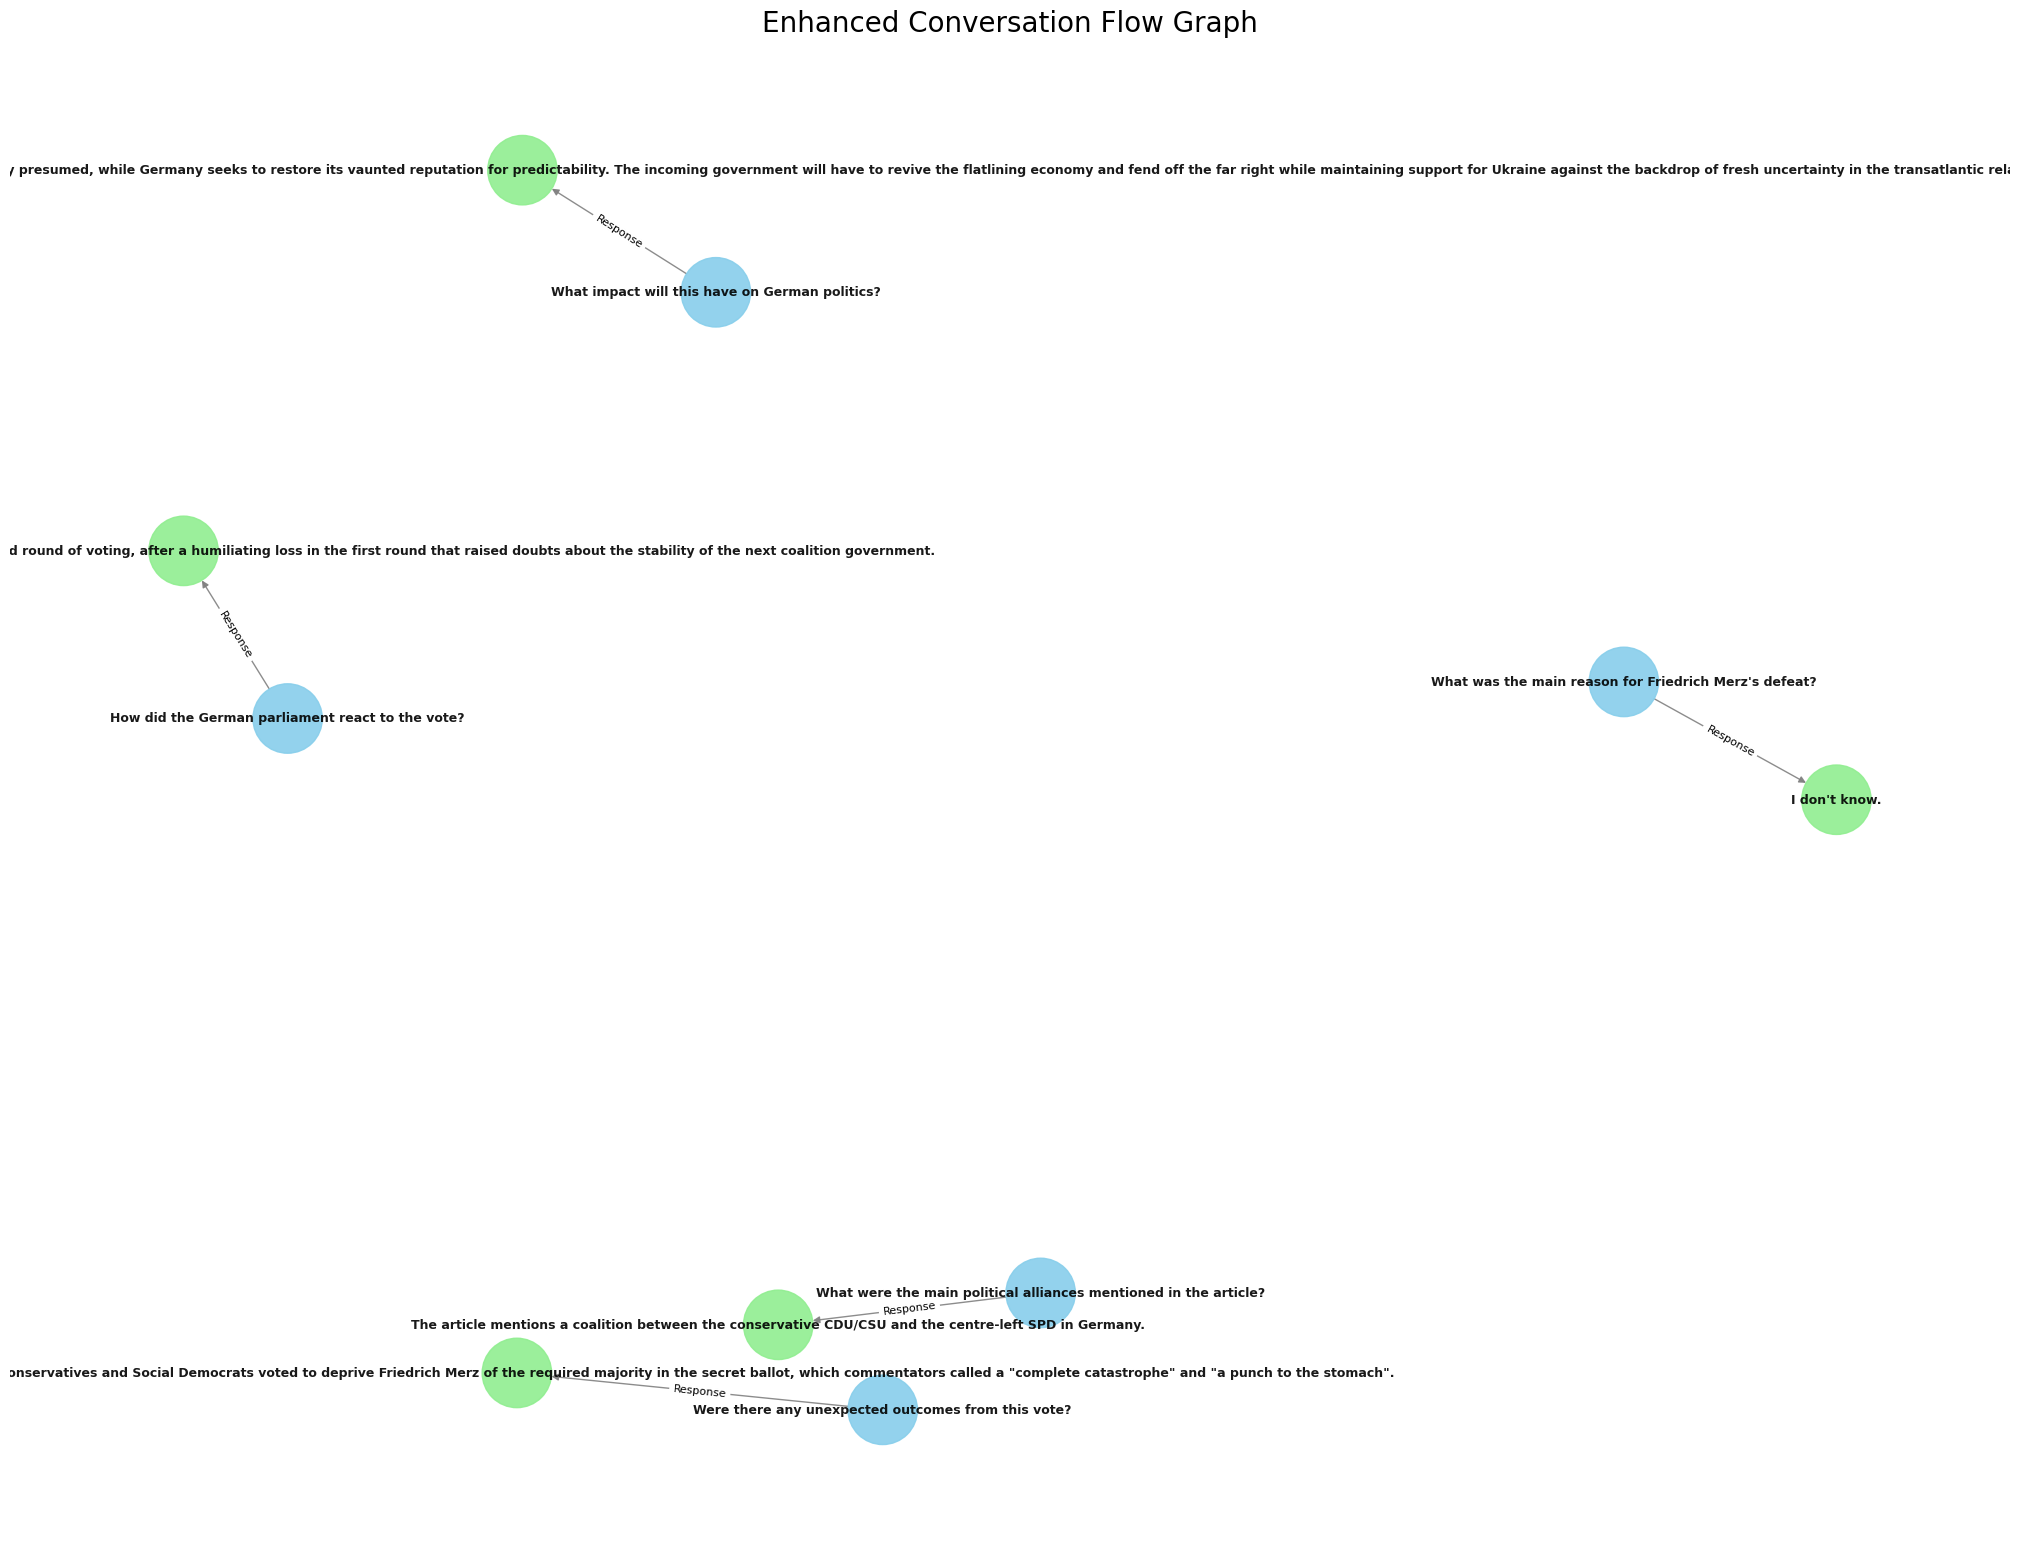

✅ Chat history saved to 'chat_history.txt' and 'chat_history.json'
✅ All steps completed successfully!


In [3]:
# ✅ Step 1: Install necessary libraries
!pip install -qU "langchain[google-genai]" chromadb networkx matplotlib
!pip install langchain-community
!pip install -qU sentence-transformers transformers langchain-huggingface langchain-chroma langchain

# ✅ Step 2: Import necessary libraries
import os
import networkx as nx
import matplotlib.pyplot as plt
from langchain_chroma import Chroma
from langchain_huggingface import HuggingFaceEmbeddings
from langchain.chains import RetrievalQAWithSourcesChain
from langchain.prompts import PromptTemplate
from langchain.memory import ConversationBufferMemory
from langchain.callbacks.tracers import LangChainTracer
from langchain.callbacks.manager import CallbackManager
from langchain.chat_models import init_chat_model
from langchain.text_splitter import RecursiveCharacterTextSplitter
import getpass
import json

# ✅ Error handling for missing API keys

def set_env_variable(key_name, prompt_text):
    if not os.environ.get(key_name):
        os.environ[key_name] = getpass.getpass(prompt_text)

set_env_variable("LANGSMITH_API_KEY", "Enter your LANGSMITH_API_KEY: ")
set_env_variable("GOOGLE_API_KEY", "Enter your GOOGLE_API_KEY: ")

# ✅ Set up Langsmith tracing and API key
os.environ["LANGSMITH_PROJECT"] = "Gemini_Project_2025"
os.environ["LANGSMITH_TRACING_V2"] = "true"
os.environ["LANGSMITH_ENDPOINT"] = "https://api.smith.langchain.com"

# ✅ Initialize the LangSmith tracer and callback manager
tracer = LangChainTracer(project_name="Gemini_Project_2025")
callback_manager = CallbackManager([tracer])

# ✅ Document Download and Splitting
def download_and_split_document(url, chunk_size=500, chunk_overlap=50):
    !wget -O article.txt {url}
    with open("article.txt", "r", encoding="utf-8") as f:
        document_text = f.read()
    text_splitter = RecursiveCharacterTextSplitter(chunk_size=chunk_size, chunk_overlap=chunk_overlap)
    chunks = text_splitter.split_text(document_text)
    assert len(chunks) >= 50, f"Expected at least 50 chunks, but got {len(chunks)}"
    return chunks

chunks = download_and_split_document(
    "https://www.theguardian.com/world/2025/may/06/friedrich-merz-suffers-shock-defeat-in-german-parliament-vote-for-chancellor?utm_source=chatgpt.com"
)

# ✅ ChromaDB Initialization
def initialize_chromadb(chunks, persist_directory="chroma_langchain_db"):
    embedding_function = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")
    vectorstore = Chroma(
        collection_name="example_collection",
        embedding_function=embedding_function,
        persist_directory=persist_directory
    )
    for i, chunk in enumerate(chunks):
        vectorstore.add_texts([chunk], metadatas=[{"chunk_id": i, "source": f"Article_Chunk_{i}"}])
    return vectorstore

vectorstore = initialize_chromadb(chunks)

# ✅ Model Initialization
def initialize_model():
    return init_chat_model("gemini-2.0-flash", model_provider="google_genai")

llm = initialize_model()

# ✅ Retrieval Chain Initialization
def initialize_retrieval_chain(llm, vectorstore):
    retriever = vectorstore.as_retriever()
    return RetrievalQAWithSourcesChain.from_chain_type(
        llm=llm,
        retriever=retriever,
        chain_type="stuff"
    )

qa_chain = initialize_retrieval_chain(llm, vectorstore)

# ✅ Memory Initialization
memory = ConversationBufferMemory(memory_key="history")
template = PromptTemplate.from_template("{history}\nUser: {question}\nAI:")

# ✅ Graph Storage for Final Visualization
conversation_graph = nx.DiGraph()

# ✅ Prompt Variation Testing
def run_prompt_variations(qa_chain, memory, prompts):
    for q in prompts:
        history = memory.chat_memory.messages if memory.chat_memory else []
        response = qa_chain.invoke({"question": q, "history": history})  # ✅ Updated to use invoke()
        print(f"Q: {q}\nA: {response['answer']}\nSources: {response['sources']}\n")
        memory.chat_memory.add_user_message(q)
        memory.chat_memory.add_ai_message(response["answer"])
        question_node = q.strip()
        answer_node = response["answer"].strip()
        conversation_graph.add_node(question_node, color='skyblue', label='User Question')
        conversation_graph.add_node(answer_node, color='lightgreen', label='AI Response')
        conversation_graph.add_edge(question_node, answer_node, label='Response')

# ✅ Run Prompt Variations
prompts = [
    "What was the main reason for Friedrich Merz's defeat?",
    "How did the German parliament react to the vote?",
    "What impact will this have on German politics?",
    "Were there any unexpected outcomes from this vote?",
    "What were the main political alliances mentioned in the article?"
]

run_prompt_variations(qa_chain, memory, prompts)

# ✅ Metadata Filtering and Multi-Query Retrieval
def run_metadata_and_multi_query(qa_chain, memory):
    filtered_retriever = vectorstore.as_retriever(search_kwargs={"filters": {"chunk_id": {"$lt": 30}}})
    multi_query_prompts = [
        "Why did Friedrich Merz lose the vote?",
        "What factors contributed to Merz's defeat?",
        "How did Merz's political opponents respond?"
    ]
    for q in multi_query_prompts:
        history = memory.chat_memory.messages if memory.chat_memory else []
        response = qa_chain.invoke({"question": q, "history": history})  # ✅ Updated to use invoke()
        print(f"Multi-Query Q: {q}\nA: {response['answer']}\nSources: {response['sources']}\n")
        memory.chat_memory.add_user_message(q)
        memory.chat_memory.add_ai_message(response["answer"])

run_metadata_and_multi_query(qa_chain, memory)

# ✅ Final Graph Visualization
plt.figure(figsize=(20, 15))
pos = nx.spring_layout(conversation_graph, seed=42, k=0.5)
node_colors = [conversation_graph.nodes[node]['color'] for node in conversation_graph.nodes]
nx.draw(conversation_graph, pos, with_labels=True, node_size=2500, node_color=node_colors, font_size=9, font_weight="bold", edge_color="gray", arrows=True, alpha=0.9)
nx.draw_networkx_edge_labels(conversation_graph, pos, edge_labels={(u, v): d['label'] for u, v, d in conversation_graph.edges(data=True)}, font_size=8, font_color='black')
plt.title("Enhanced Conversation Flow Graph", fontsize=20)
plt.show()

# ✅ Save Chat History to File
def save_chat_history(memory, text_file="chat_history.txt", json_file="chat_history.json"):
    # Extract the chat history
    messages = memory.chat_memory.messages if memory.chat_memory else []

    # Save as plain text
    with open(text_file, "w", encoding="utf-8") as f:
        for msg in messages:
            role = "User" if msg.type == "human" else "AI"
            f.write(f"{role}: {msg.content}\n")

    # Save as JSON
    with open(json_file, "w", encoding="utf-8") as f:
        json.dump([{"role": "User" if msg.type == "human" else "AI", "message": msg.content} for msg in messages], f, ensure_ascii=False, indent=4)

    print(f"✅ Chat history saved to '{text_file}' and '{json_file}'")

# ✅ Save the chat history
save_chat_history(memory)

print("✅ All steps completed successfully!")